Copyright (c) Meta Platforms, Inc. and affiliates.

Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Refined SAM2 model for in-focus bubble masking



## SAM2 Setup Script for Google Colab

This script initializes a Colab environment for using Meta AI's SAM2 (Segment Anything Model v2). It verifies GPU availability, installs necessary dependencies, and sets up the directory for storing model checkpoints.

Note: Meta recommends using A100 or L4 GPUs


In [ ]:
# Ensure a CUDA-enabled GPU is available
import torch; assert torch.cuda.is_available()

# Import torchvision and verify PyTorch + CUDA versions
import torchvision;
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# Install OpenCV and matplotlib for image processing and visualization
import sys;
!{sys.executable} -m pip install opencv-python matplotlib

# Install SAM2 directly from the GitHub repository
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

# Create a directory to store model checkpoint files
!mkdir -p ../checkpoints/


PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-pnc7td04
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-pnc7td04
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Device Setup and Interactive Mask Filtering in SAM2 (Colab)

This script configures the PyTorch execution device (CUDA, MPS, or CPU), sets numerical precision options, and defines utility functions for visualizing and interactively filtering SAM2 segmentation masks based on IoU and stability scores. It includes contour rendering and matplotlib widget sliders for live updates.


In [ ]:
import os
# Enable fallback to CPU for unsupported Metal Performance Shaders (MPS) ops (Mac-only)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Core dependencies
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, CheckButtons
from PIL import Image
import cv2

# Install ipywidgets for interactive filtering
!pip install ipywidgets --quiet
import ipywidgets as widgets
from IPython.display import display, clear_output

# Select best available device for torch computations
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

# Configure precision for CUDA or MPS
if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()  # Enable mixed precision
    if torch.cuda.get_device_properties(0).major >= 8:  # Ampere or newer
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# Set random seed for reproducibility
np.random.seed(3)

# Function to show segmentation masks with optional smoothed borders
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

# Add interactive controls for filtering masks by predicted IoU and stability score
def interactive_mask_filter(image, masks, max_area=2000):
    image_rgb = image / 255.0 if image.max() > 1 else image

    # Initial slider thresholds
    init_iou_thresh = 0.85
    init_stability_thresh = 0.85

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.subplots_adjust(left=0.25, bottom=0.3)

    img_display = ax.imshow(image_rgb)
    mask_overlay = ax.imshow(np.zeros_like(image_rgb), alpha=0.5)
    ax.axis('off')
    ax.set_title("Interactive Mask Filter")

    # Create sliders for IoU and stability thresholds
    ax_iou = plt.axes([0.25, 0.2, 0.65, 0.03])
    ax_stability = plt.axes([0.25, 0.15, 0.65, 0.03])
    s_iou = Slider(ax_iou, 'Min IoU', 0.8, 1.0, valinit=init_iou_thresh, valstep=0.01)
    s_stability = Slider(ax_stability, 'Min Stability', 0.8, 1.0, valinit=init_stability_thresh, valstep=0.01)

    # Checkbox to toggle mask visibility
    ax_check = plt.axes([0.025, 0.7, 0.15, 0.15])
    check = CheckButtons(ax_check, ['Show Masks'], [True])

    # Update mask overlay based on slider/checkbox states
    def update(val=None):
        iou_thresh = s_iou.val
        stab_thresh = s_stability.val
        show_masks = check.get_status()[0]

        overlay = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.float32)

        if show_masks:
            filtered = [
                m for m in masks
                if m['area'] < max_area
                and m['predicted_iou'] >= iou_thresh
                and m['stability_score'] >= stab_thresh
            ]

            if filtered:
                ious = np.array([m['predicted_iou'] for m in filtered])
                norm_ious = (ious - 0.8) / (1.0 - 0.8 + 1e-8)
                for m, norm_iou in zip(filtered, norm_ious):
                    mask = m['segmentation']
                    color = plt.cm.plasma(norm_iou)
                    overlay[mask] = color

        blended = (1 - overlay[..., 3:]) * image_rgb + overlay[..., :3] * overlay[..., 3:]
        mask_overlay.set_data(blended)
        fig.canvas.draw_idle()

    s_iou.on_changed(update)
    s_stability.on_changed(update)
    check.on_clicked(update)

    update()
    plt.show()




using device: cuda


## Load and Display an Image from Google Drive (Colab)

This code mounts your Google Drive in Colab, loads a specific image file from it, converts the image to RGB format, and displays it using `matplotlib`. This is useful for visualizing input data such as video frames or segmentation targets stored in Drive.

Note: This function has only been tested w/ uploaded grayscale images. RGB is used for consistency w/ meta's functions to not mess with image dimensions

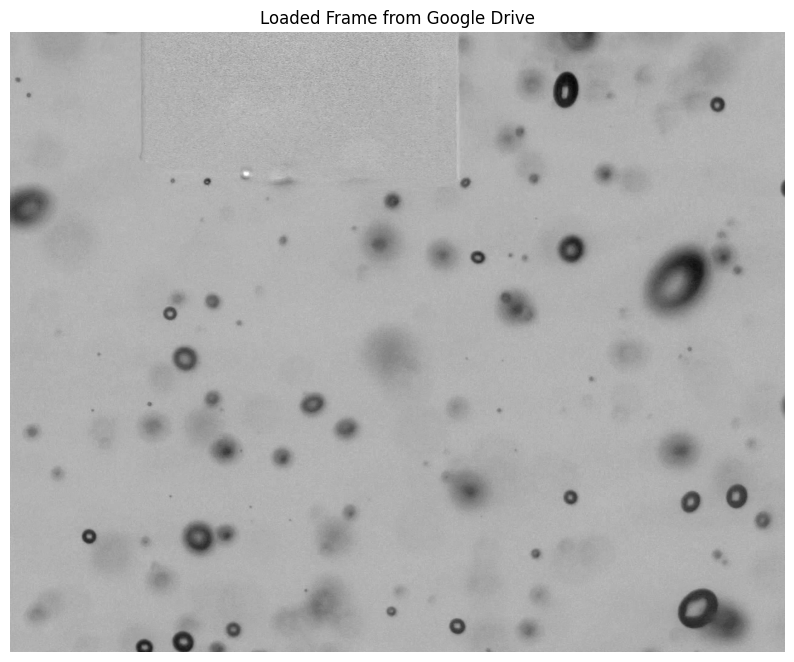

In [ ]:
# Mount Google Drive only if not already mounted
if not os.path.exists("/content/drive/MyDrive"):
    from google.colab import drive
    drive.mount('/content/drive')

# Load Image from Drive
image_path = "/content/drive/MyDrive/Master's Data Processing/Thesis Data/15 Degree/180F/0_2 Percent Trial 2/4_5/3 - Normalized/Frame_0291.png"
image = Image.open(image_path)
image = np.array(image.convert("RGB"))

# Display Image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Loaded Frame from Google Drive")
plt.show()


## SAM2 Model Loader and Checkpoint Downloader (Colab)

This script selects a SAM2 model size (e.g., tiny, small, base_plus, large), ensures the model checkpoint is downloaded, and loads the model onto the GPU (or CPU if needed). It uses the SAM2 configuration files and checkpoint registry for reproducibility and modularity in Google Colab environments.

See [Meta Link](https://github.com/facebookresearch/sam2/tree/main?tab=readme-ov-file#sam-21-checkpoints) for model size descriptions

In [ ]:
import os
import subprocess
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Choose Model
model_choice = "tiny"  # Options: "tiny", "small", "base_plus", "large"

# Paths for model checkpoints and configs
base_ckpt_path = "../checkpoints" #checkpoints is located one level above contents
cfg_dir = "configs/sam2.1"

# Registry of model filenames and associated YAML config files
sam2_models = {
    "tiny":       ("sam2.1_hiera_tiny.pt",      "sam2.1_hiera_t.yaml"),
    "small":      ("sam2.1_hiera_small.pt",     "sam2.1_hiera_s.yaml"),
    "base_plus":  ("sam2.1_hiera_base_plus.pt", "sam2.1_hiera_b.yaml"),
    "large":      ("sam2.1_hiera_large.pt",     "sam2.1_hiera_l.yaml")
}

# URLs for downloading model checkpoints from Meta's storage
sam2_urls = {
    "tiny":      "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt",
    "small":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt",
    "base_plus": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt",
    "large":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
}

# Resolve full paths to the checkpoint and config files
ckpt_file, cfg_file = sam2_models[model_choice]
ckpt_path = os.path.join(base_ckpt_path, ckpt_file)
cfg_path = os.path.join(cfg_dir, cfg_file)

# Download the checkpoint if it's not already present
if not os.path.exists(ckpt_path):
    print(f"[INFO] Checkpoint '{ckpt_file}' not found. Downloading from Meta URL...")
    url = sam2_urls[model_choice]
    subprocess.run(["wget", "-P", base_ckpt_path, url], check=True)
else:
    print(f"[INFO] Checkpoint '{ckpt_file}' found.")

# Load the SAM2 model using the selected config and checkpoint
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
sam2 = build_sam2(cfg_path, ckpt_path, device=device, apply_postprocessing=False)
print(f"[INFO] Loaded SAM2 model: {model_choice}")

[INFO] Checkpoint 'sam2.1_hiera_tiny.pt' found.
[INFO] Loaded SAM2 model: tiny


## Static Sobel Edge Detection with Visualization (Colab)

This script applies the Sobel operator [[Wiki]](https://en.wikipedia.org/wiki/Sobel_operator) to a grayscale version of the image using a fixed kernel size (`ksize`). It computes the edge magnitude and displays both the original image and the resulting edge-detected image side-by-side. The normalized magnitude array is stored in the global variable `sobel_mag_current` which gets used by future functions for determining regions of interest.


You can mess with the kernel/convolution size. Higher numbers produce smoother gradients/is more robust to noise but might miss thin edges. In our testing I pretty almost used 9, and an `edge_thresh` of 90 in the following section. If you change the kernel size, be prepared to mess with the threshold to achieve desired results.


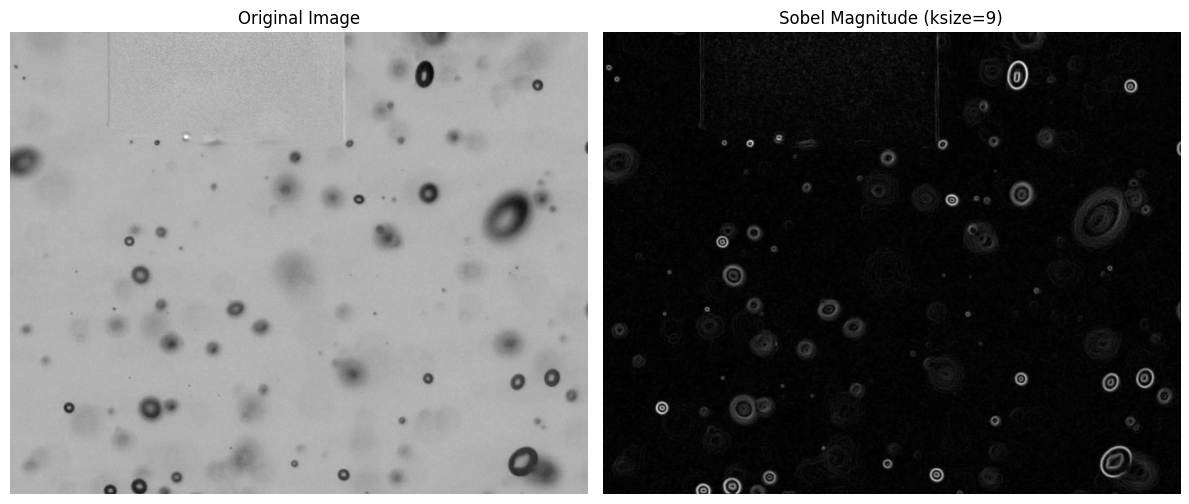

In [ ]:
import cv2

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Set Sobel kernel size
ksize = 9  # Must be odd: 1, 3, 5, 7, or 9

# Apply Sobel operator in X and Y directions
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

# Compute magnitude of the gradient
sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)

# Normalize magnitude to [0, 255] and convert to uint8
sobel_mag_norm = (sobel_mag / sobel_mag.max() * 255).astype(np.uint8)

# Store result in global variable for downstream processing
sobel_mag_current = sobel_mag_norm

# Display the original image and Sobel magnitude side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sobel_mag_norm, cmap='gray')
plt.title(f"Sobel Magnitude (ksize={ksize})")
plt.axis("off")

plt.tight_layout()
plt.show()


## Generate Bounding Boxes and Prompt Points from Edges + Multi-Scale SAM2 Masking

This script defines three utility functions for integrating contour-based edge detection with SAM2 box+point prompting workflows:

1. `generate_boxes_and_points_from_contours()`:
   Detects edges (e.g., from a Sobel image), extracts bounding boxes, and generates prompt points within each region.
2. `visualize_prompts_on_image()`:
   Plots those boxes and points on top of the original image.

### Parameters in `generate_boxes_and_points_from_contours`:
- `image`: The original image (used to set bounds)
- `sobel_mag`: Precomputed gradient magnitude image from Sobel
- `edge_thresh`: Threshold value to binarize edge magnitude (default: `90`)
- `min_contour_len`: Minimum number of points in a contour to keep (default: `10`) -> make this larger if you don't ahve tiny bubbles to work with
- `padding_px`: Number of pixels to pad around each bounding box (default: `0`)
- `grid_size`: Number of points along x and y to place within the box (default: `3`)


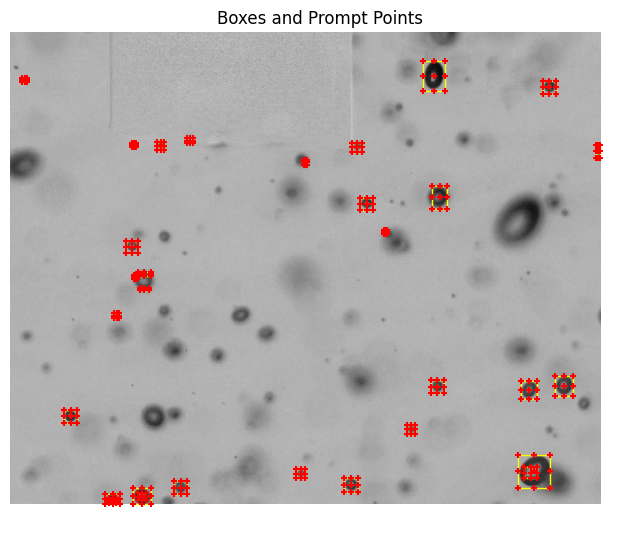

In [ ]:
def generate_boxes_and_points_from_contours(
    image: np.ndarray,
    sobel_mag: np.ndarray,
    edge_thresh: int = 90,
    min_contour_len: int = 10,
    padding_px: int = 0,
    grid_size: int = 3
) -> tuple[list[list[int]], list[list[tuple[float,float]]]]:
    """
    Returns:
      boxes:    List of [x0, y0, x1, y1]
      points:   List of list of (x, y) prompts inside that box
    """
    # 1) find contours
    _, edge_mask = cv2.threshold(sobel_mag, edge_thresh, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(edge_mask.astype(np.uint8),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    H, W = image.shape[:2]
    boxes = []
    points_for_box = []

    for cnt in contours:
        if len(cnt) < min_contour_len:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        x0 = max(x - padding_px, 0)
        y0 = max(y - padding_px, 0)
        x1 = min(x + w + padding_px, W)
        y1 = min(y + h + padding_px, H)
        boxes.append([x0, y0, x1, y1])

        # 2) compute center + small grid of points
        cx, cy = x0 + w/2, y0 + h/2
        pts = [(cx, cy)]  # always include center

        # optional: add a normalized grid of points
        xs = np.linspace(x0, x1, grid_size)
        ys = np.linspace(y0, y1, grid_size)
        for xx in xs:
            for yy in ys:
                pts.append((float(xx), float(yy)))

        points_for_box.append(pts)

    return boxes, points_for_box
def visualize_prompts_on_image(image: np.ndarray,
                               boxes: list[list[int]],
                               points_for_box: list[list[tuple[float, float]]]):
    """
    Display the image with bounding boxes and prompt points overlaid.

    Args:
      image: HxWxC or HxW numpy array
      boxes: list of [x0, y0, x1, y1]
      points_for_box: list of lists of (x, y) points inside each box
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    # show image
    if image.ndim == 2:
        ax.imshow(image, cmap='gray')
    else:
        ax.imshow(image)
    # draw boxes
    for (x0, y0, x1, y1) in boxes:
        rect = plt.Rectangle((x0, y0), x1-x0, y1-y0,
                             edgecolor='yellow', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    # draw points
    for pts in points_for_box:
        xs = [pt[0] for pt in pts]
        ys = [pt[1] for pt in pts]
        ax.scatter(xs, ys, marker='+', color='red', s=20)
    ax.set_title("Boxes and Prompt Points")
    ax.axis('off')
    plt.show()

boxes, all_points = generate_boxes_and_points_from_contours(image, sobel_mag_current, edge_thresh=90, min_contour_len=10, padding_px=0)
visualize_prompts_on_image(image, boxes, all_points)


## Function Definition (`multi_scale_box_masks`) (Returns Mask, IoU, and Logits)

This function runs the SAM2 predictor on a single box+point prompt across multiple padded versions of the crop. It returns the mask with the **highest predicted IoU**, along with the associated IoU score and the raw logits used for computing mask stability or confidence. This strategy was adapted from that used by Meta's [Automatic Mask Generation](https://github.com/facebookresearch/sam2/blob/2b90b9f5ceec907a1c18123530e92e794ad901a4/sam2/automatic_mask_generator.py#L36), but is a bit simpler, since we are dealing with simple shapes (bubbles) in a defined crop box.

I recommend using some smaller and some larger versions of the original crop box for the best results.

### Parameters:
- `predictor`: A `SAM2ImagePredictor` instance that has already been initialized and had `set_image(image)` called.
- `image`: Full input image as an `HxWxC` or `HxW` NumPy array, used to enforce crop boundaries.
- `box`: A list `[x0, y0, x1, y1]` specifying the bounding box region.
- `point`: A tuple `(px, py)` with a single point coordinate inside the box.
- `pad_ratios`: A list of floats specifying how much to pad the box by (as a fraction of width/height).

### Returns:
- `mask`: The best boolean mask (as a 2D NumPy array)
- `iou`: The predicted IoU score of the best mask
- `logits`: The raw logits associated with that mask (same shape as `mask`)


In [ ]:
def multi_scale_box_masks(predictor, image, box, point, pad_ratios=[0.0, 0.2, 0.4]):
    """
    For one box+point, run SAM2 on several padded crops and return best mask.
    """
    H, W = image.shape[:2]
    masks, ious, logits_all = [], [], []

    for pr in pad_ratios:
        # Compute padded crop from box
        x0, y0, x1, y1 = box
        w, h = x1 - x0, y1 - y0
        dx, dy = w * pr, h * pr

        # Ensure padded region is within image bounds
        crop = [
            max(0, x0 - dx),
            max(0, y0 - dy),
            min(W, x1 + dx),
            min(H, y1 + dy)
        ]

        # Format point prompt for SAM2 input
        pc = np.array([[point]], dtype=float)  # shape: (1, 1, 2)
        pl = np.array([[1]], dtype=int)        # label: foreground

        # Run prediction on the padded crop
        masks_pred, ious_pred, logits = predictor.predict(
            box=np.array([crop], dtype=float),
            point_coords=pc,
            point_labels=pl,
            multimask_output=False,
            return_logits=True
        )

        # Store outputs from this scale
        masks.append(masks_pred[0])
        ious.append(float(ious_pred[0]))
        logits_all.append(logits[0])

    # Select the mask with the highest IoU
    best = int(np.argmax(ious))
    return masks[best], ious[best], logits_all[best]


## Generate Annotations from Sobel-Based Boxes Using SAM2 (Multi-Scale + Stability Filtering)

This script takes in bounding boxes generated from Sobel edge detection and for each one:

- Selects a **center point** as a prompt
- Runs a **multi-scale SAM2 prediction** using positively and negatively padded crops
- Extracts the **best mask** based on predicted IoU
- Computes a **stability score** using raw logits
- Converts the result into a standardized **annotation format** compatible with Meta's `show_anns()` function

The key SAM2 parameters used:
- `mask_threshold`: Minimum score to accept a predicted mask (default: `0.8`)
- `max_hole_area`, `max_sprinkle_area`: Used to clean up small specks and holes in masks


In [ ]:
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.utils.amg import calculate_stability_score
# 1) Instantiate SAM2 predictor
predictor = SAM2ImagePredictor(
    sam2,
    mask_threshold=0.8,
    max_hole_area=500,
    max_sprinkle_area=30,
)

# 2) Run multi-scale box-based predict
anns = []
predictor.set_image(image)

for box, pts in zip(boxes, all_points):
    center_point = pts[0]

    # Run multi-scale prediction (returns single best mask, iou, and logits)
    mask_pred, iou_score, logits = multi_scale_box_masks(
        predictor, image, box, center_point
    )

    # 1) threshold the predicted mask to boolean
    mask = mask_pred > predictor.mask_threshold

    # 2) stability (from logits)
    L = torch.as_tensor(logits)
    if L.ndim == 2:
        L = L.unsqueeze(0).unsqueeze(0)
    elif L.ndim == 3:
        L = L.unsqueeze(1)
    stab = calculate_stability_score(L, predictor.mask_threshold, threshold_offset=1.0)
    stability_score = float(stab[0])

    # 3) Format box info
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    bbox_xywh = [int(x0), int(y0), int(w), int(h)]
    crop_box = bbox_xywh.copy()

    # 4) Save result
    ann = {
        "segmentation": mask,
        "area": int(mask.sum()),
        "bbox": bbox_xywh,
        "predicted_iou": iou_score,
        "point_coords": pts,
        "stability_score": stability_score,
        "crop_box": crop_box,
    }
    anns.append(ann)

print(f"Generated {len(anns)} masks with box-point prompts")


/usr/local/lib/python3.11/dist-packages/sam2/sam2_image_predictor.py:431: UserWarning: /usr/local/lib/python3.11/dist-packages/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


Generated 31 masks with box-point prompts


## Plot the raw generated masks


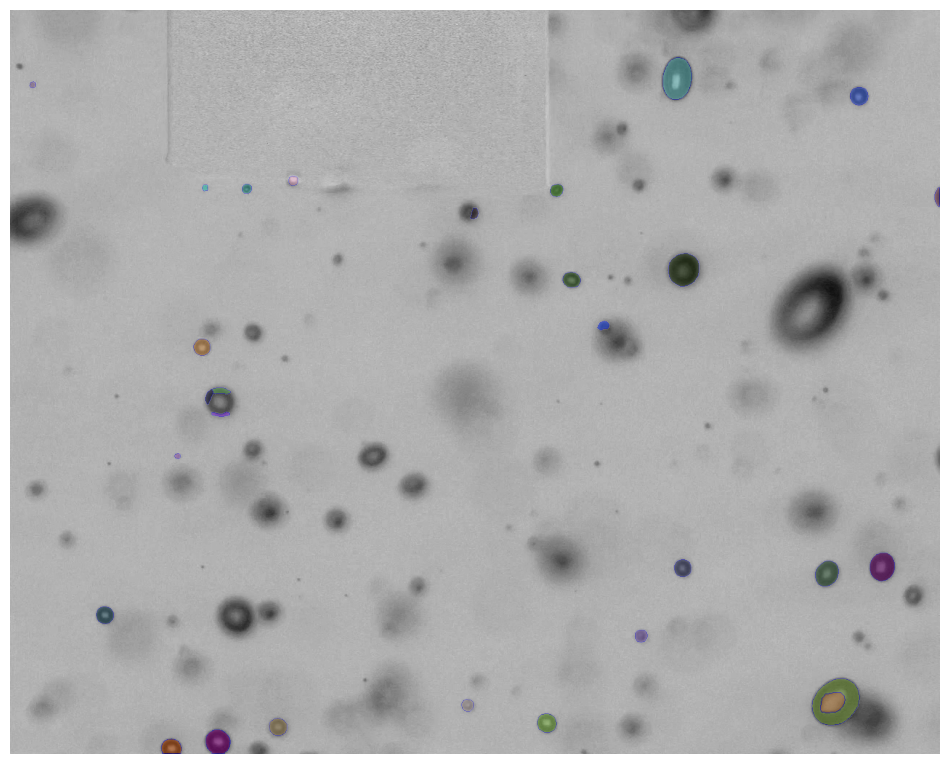

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image, cmap="gray")
plt.axis("off")
show_anns(anns,borders=True)
plt.show()


## Interactive Mask Viewer (Optional) and Filtering Utilities for SAM2 Raw Output

This code provides tools for cleaning up and reviewing the raw masks:

- **Overlaying masks** on the image in color for visual inspection
- **Interactivity** with sliders to filter masks by predicted IoU and stability score
- **Post-processing utilities**:
  - Removing masks contained within others
  - Filling internal holes
  - Applying a consistent formatting for visualization (`show_anns`-compatible)

### Highlights:
- Magenta masks represent high-confidence regions
- Green masks (optional) can represent split masks from further refinement
- All outputs are compatible with Meta's `show_anns()` format


Deleted 0 contained masks


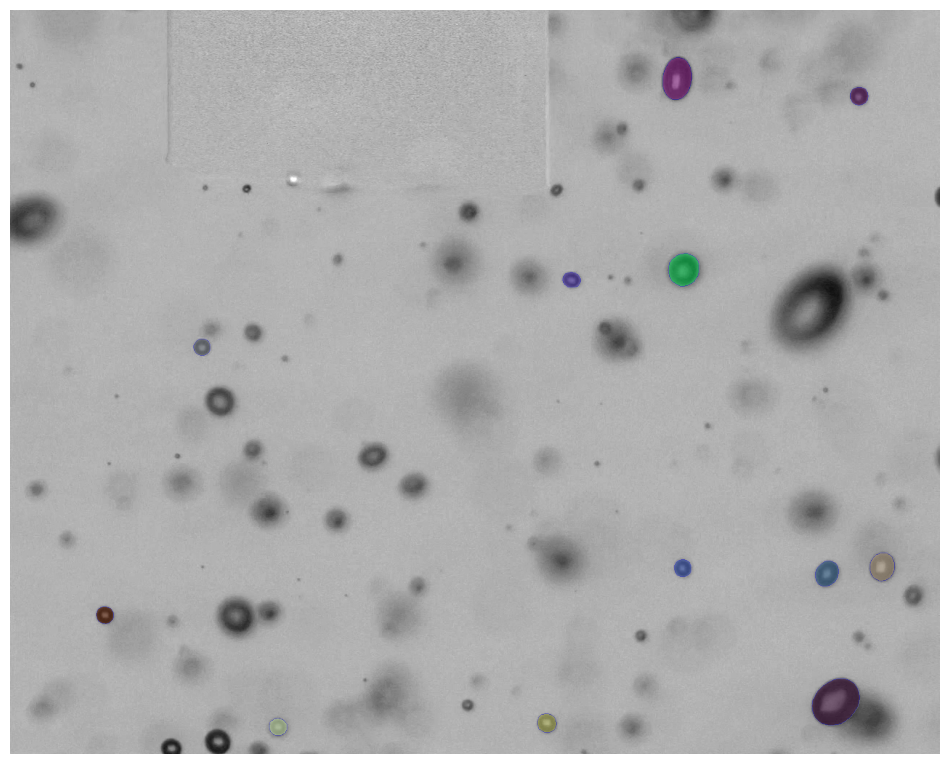

In [ ]:
def apply_colored_mask(image, mask, color=(255, 0, 255), alpha=0.4):
    """
    Overlay a binary mask on an image using a specified RGB color and transparency.

    Args:
        image: np.ndarray, original grayscale or RGB image
        mask: np.ndarray, binary mask to overlay
        color: RGB tuple (default: magenta)
        alpha: transparency (0 = transparent, 1 = opaque)

    Returns:
        overlay: image with mask applied
    """
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)  # convert grayscale to RGB
    overlay = image.copy()
    mask = mask.astype(bool)

    for c in range(3):
        overlay[..., c] = np.where(mask,
                                   (1 - alpha) * overlay[..., c] + alpha * color[c],
                                   overlay[..., c])
    return overlay.astype(np.uint8)


def interactive_mask_filter_viewer(image, anns, split_masks=None):
    """
    Display original image and annotated masks with IoU/Stability sliders.

    Args:
        image: input image (RGB or grayscale)
        anns: list of annotations in SAM2 format
        split_masks: optional list of additional masks to overlay in green
    """
    iou_slider = widgets.FloatSlider(value=0.85, min=0.8, max=1.0, step=0.01,
                                     description='IoU ≥', continuous_update=False)
    stab_slider = widgets.FloatSlider(value=0.85, min=0.8, max=1.0, step=0.01,
                                      description='Stability ≥', continuous_update=False)
    out = widgets.Output()

    def update(change=None):
        with out:
            clear_output(wait=True)
            iou_thresh = iou_slider.value
            stab_thresh = stab_slider.value

            # Filter masks based on thresholds
            filtered = [
                ann for ann in anns
                if ann["predicted_iou"] >= iou_thresh and ann["stability_score"] >= stab_thresh
            ]

            # Set up display
            fig, axs = plt.subplots(1, 2, figsize=(14, 7))

            axs[0].imshow(image, cmap='gray' if image.ndim == 2 else None)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            base_img = image if image.ndim == 3 else np.stack([image]*3, axis=-1)
            overlay_img = base_img.copy()

            # Overlay high-confidence masks (magenta)
            for ann in filtered:
                overlay_img = apply_colored_mask(overlay_img, ann["segmentation"],
                                                 color=(255, 0, 255), alpha=0.4)

            # Overlay additional split masks if provided (green)
            if split_masks is not None:
                for region in split_masks:
                    overlay_img = apply_colored_mask(overlay_img, region,
                                                     color=(0, 255, 0), alpha=0.4)

            axs[1].imshow(overlay_img)
            axs[1].set_title(f"Masks (IoU ≥ {iou_thresh:.2f}, Stability ≥ {stab_thresh:.2f})")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()

    # Hook slider changes to update display
    iou_slider.observe(update, names='value')
    stab_slider.observe(update, names='value')

    display(widgets.VBox([iou_slider, stab_slider, out]))
    update()


def filter_contained_masks(anns, threshold=0.9):
    """
    Removes masks mostly contained within others (e.g., duplicates).

    Args:
        anns: list of annotations (must include 'segmentation')
        threshold: overlap ratio (default: 0.9)

    Returns:
        Filtered list of anns
    """
    keep = []
    masks = [ann["segmentation"] for ann in anns]
    N = len(masks)
    count = 0

    for i in range(N):
        mask_i = masks[i]
        area_i = mask_i.sum()
        if area_i == 0:
            continue

        contained = False
        for j in range(N):
            if i == j:
                continue
            mask_j = masks[j]
            overlap = np.logical_and(mask_i, mask_j).sum()
            if overlap / area_i > threshold:
                contained = True
                count += 1
                break

        if not contained:
            keep.append(anns[i])

    print(f"Deleted {count} contained masks")
    return keep


from scipy.ndimage import binary_fill_holes

def fill_mask_holes(anns):
    """
    Returns new list of masks with internal holes filled.

    Args:
        anns: list of annotation dicts with binary 'segmentation' masks

    Returns:
        anns_filled: same structure, but with filled-in masks
    """
    anns_filled = []

    for ann in anns:
        mask = ann["segmentation"]
        filled = binary_fill_holes(mask).astype(bool)

        new_ann = ann.copy()
        new_ann["segmentation"] = filled
        anns_filled.append(new_ann)

    return anns_filled


# Filter out redundant or fully nested masks before any splitting
anns = filter_contained_masks(anns, threshold=0.60)
anns = fill_mask_holes(anns)

# Use to visualize thresholds and adjust accordingly
#interactive_mask_filter_viewer(image, anns)

# ADJUST THESE to actually filter based on iou and stability
iou_threshold = 0.94
stability_threshold = 0.94
anns_hq = [ann for ann in anns if ann["predicted_iou"] >= iou_threshold and ann["stability_score"] >= stability_threshold]

plt.figure(figsize=(12,12))
plt.imshow(image, cmap="gray")
plt.axis("off")
show_anns(anns_hq,borders=True)
plt.show()




## Watershed-Based Mask Splitting and Visualization for SAM2 Masks

Uses a distance transform + watershed segmentation technique to **split connected mask regions** (e.g., merged bubbles) into distinct components. The resulting split masks are then visualized along with the original SAM2 masks using random colors.

### Main Features:
- Applies `cv2.distanceTransform` to compute distances from edges within each mask
- Finds local maxima as **potential region centers** using `scipy.ndimage.maximum_filter`
- Runs `cv2.watershed` to segment connected regions
- Filters out very small or very large regions by area
- Displays all masks (original + split) in random colors for inspection

### Parameters in `split_mask_with_watershed()`:
- `mask`: binary input mask to be split
- `min_peaks`: minimum number of local maxima required to attempt splitting (we only try w/ 2)
- `min_region_area`: minimum pixel area for a region to be retained
- `max_region_area`: optional maximum pixel area threshold
- `peak_filter_size`: size of filter window used for local maxima detection


0 split masks extracted (area-filtered)
Displaying 12 total masks


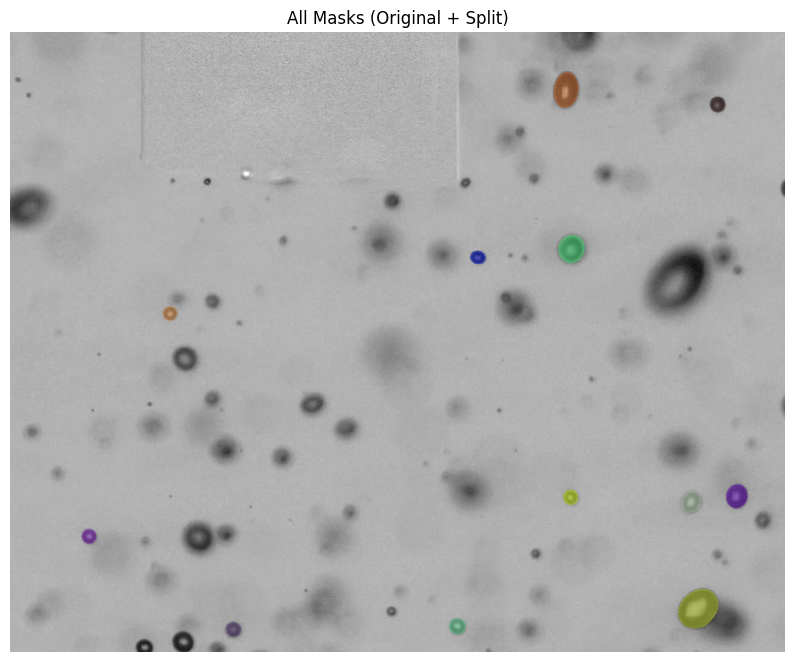

In [ ]:
from scipy import ndimage
import matplotlib.colors as mcolors

def split_mask_with_watershed(mask, min_peaks=2, min_region_area=30,
                               max_region_area=None, peak_filter_size=15):
    """
    Uses distance transform + watershed to split connected regions in a binary mask.

    Args:
        mask: binary 2D mask to be split
        min_peaks: minimum number of distinct peaks required to run watershed
        min_region_area: minimum pixel area to retain a region
        max_region_area: (optional) maximum pixel area to retain a region
        peak_filter_size: window size for local maxima filtering

    Returns:
        List of binary masks for each valid region split from input mask
    """
    if mask.sum() < min_region_area:
        return []

    # 1. Compute Euclidean distance transform from mask edges
    dist = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 5)

    # 2. Detect local maxima as watershed seed points
    local_max = ndimage.maximum_filter(dist, size=peak_filter_size) == dist
    local_max &= mask
    markers, num_peaks = ndimage.label(local_max)

    if num_peaks < min_peaks:
        return []

    # 3. Prepare 3-channel mask for OpenCV watershed (expects RGB image)
    mask_rgb = np.stack([mask * 255] * 3, axis=-1).astype(np.uint8)
    wshed = cv2.watershed(mask_rgb, markers.astype(np.int32))

    # 4. Extract labeled regions and apply area filtering
    regions = []
    for label in np.unique(wshed):
        if label <= 0:
            continue
        region = (wshed == label)
        area = region.sum()
        if area < min_region_area:
            continue
        if max_region_area is not None and area > max_region_area:
            continue
        regions.append(region)

    return regions


def visualize_split_masks(image, anns, split_masks):
    """
    Visualizes original + split masks overlaid on the input image.

    Args:
        image: original grayscale or RGB image
        anns: list of original annotation dicts (must contain 'segmentation')
        split_masks: list of additional binary masks
    """
    all_masks = [ann['segmentation'] for ann in anns] + split_masks
    print(f"Displaying {len(all_masks)} total masks")

    # Ensure image is in RGB format
    base_img = image if image.ndim == 3 else np.stack([image]*3, axis=-1)
    overlay_img = base_img.copy()

    def random_color():
        return tuple(np.random.randint(0, 256) for _ in range(3))

    # Overlay all masks in random colors
    for mask in all_masks:
        overlay_img = apply_colored_mask(overlay_img, mask, color=random_color(), alpha=0.5)

    # Display image with overlays
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_img)
    plt.title("All Masks (Original + Split)")
    plt.axis("off")
    plt.show()

# Step 1: Run watershed-based mask splitting on each high-quality mask
split_masks = []
for ann in anns_hq:  # or anns
    mask = ann["segmentation"]
    regions = split_mask_with_watershed(
        mask,
        min_peaks=2,
        peak_filter_size=30,
        min_region_area=200,
        max_region_area=10000  # example: exclude large merged bubbles
    )
    split_masks.extend(regions)

print(f"{len(split_masks)} split masks extracted (area-filtered)")

# Step 2: Visualize the original and split masks together
visualize_split_masks(image, anns_hq, split_masks)


## Detecting and Visualizing Circular Bubbles

### 1. `get_circular_mask_properties(masks)`
This function analyzes each binary mask and returns:
- The centroid of the region
- The equivalent diameter (assuming a circle of same area)
- The circularity, defined as:

Circularity = (4π⋅A)/Perimeter^2

Only masks with defined perimeters are included.

---

### 2. `plot_detected_circles(image, properties, circularity_thresh)`
This function takes the geometric data from step 1 and overlays circles onto the original image for objects that exceed a given circularity threshold (default = 0.).

It helps visually verify whether the segmented masks correspond to circular objects like bubbles.


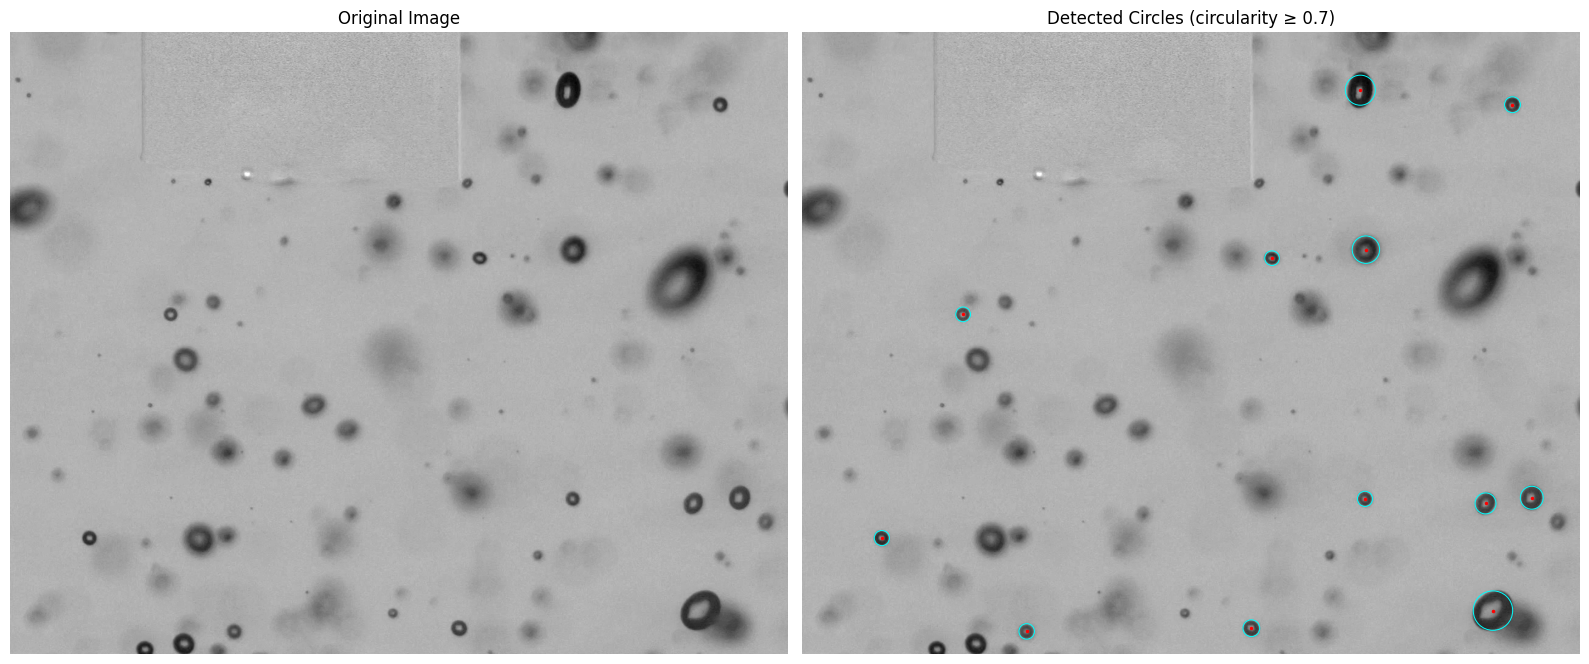

In [ ]:
from skimage.measure import regionprops, label
def get_circular_mask_properties_from_anns(anns):
    """
    Computes centroid, diameter, and circularity for each ann['segmentation'] mask.

    Parameters:
        anns: list of dicts
            Each dictionary should contain a 'segmentation' key with a binary mask.

    Returns:
        List of dictionaries with:
            'centroid': (row, col)
            'diameter': float
            'circularity': float
    """
    properties = []

    for ann in anns:
        mask = ann['segmentation']
        if mask.sum() == 0:
            continue

        # Use stored area if provided
        area = ann.get('area', int(mask.sum()))

        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours or len(contours[0]) < 5:
            continue

        perimeter = cv2.arcLength(contours[0], True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter ** 2)

        # Find region centroid using skimage
        labeled_mask = label(mask)
        region = regionprops(labeled_mask)[0]
        centroid = region.centroid  # (row, col)

        diameter = 2 * np.sqrt(area / np.pi)

        properties.append({
            'centroid': centroid,
            'diameter': diameter,
            'circularity': circularity
        })

    return properties

def plot_detected_circles(image, properties, circularity_thresh=0.6):
    """
    Plots a side-by-side comparison of:
    - Original image
    - Image with overlaid circles for high-circularity regions

    Parameters:
        image: ndarray
            Original image (grayscale or RGB).
        properties: list of dicts
            Each dict should have 'centroid', 'diameter', 'circularity'.
        circularity_thresh: float
            Minimum circularity to include region in the plot.
    """
    if image.ndim == 2:
        image_rgb = np.stack([image]*3, axis=-1)
    else:
        image_rgb = image.copy()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Original image
    axs[0].imshow(image_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Overlayed image
    axs[1].imshow(image_rgb)
    for prop in properties:
        if prop['circularity'] >= circularity_thresh:
            y, x = prop['centroid']
            r = prop['diameter'] / 2
            circle = plt.Circle((x, y), r, edgecolor='cyan', fill=False, linewidth=0.7)
            axs[1].add_patch(circle)
            axs[1].plot(x, y, 'r.', markersize=3)

    axs[1].set_title(f"Detected Circles (circularity ≥ {circularity_thresh})")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


props = get_circular_mask_properties_from_anns(anns_hq)
plot_detected_circles(image, props, circularity_thresh=0.7)
